# Heisenberg XXZ model

# 1. Imports

In [1]:

# qiskit imports
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.providers.aer.noise as noise
import sys
sys.path.append("..") # import one subdirectory up in files
#sys.path.append("..") # import one subdirectory up in files
#os.chdir("../holopy/")
import basic_circuits as circuits
from networks import IsoMPS
from isonetwork import QKParamCircuit, IsoTensor
import matplotlib.pyplot as plt

# tenpy imports
import tenpy as tp
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.spins import SpinModel
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import asConfig
from tenpy.networks.site import SpinHalfSite

# classical circuit and thermal states imports
# import thermal state
#from thermal_state import thermal_state 
from circuit_qubit1 import Circuit
from hamiltonian import model_mpo

# 2. Circuit structure

In [12]:

# model params 
J = 1 # spin-exchange
Delta = 1.25 # Ising-anisotropy
hz = 0 # z-field
L = 20 # repetition of unit-cell
l_uc = 2 # number of sites in unit cell
N = L * l_uc # number of sites
d = 2
chimax = 2
nb = 1 # number of bond-qubits
n_site_param = 2*nb # number of circuit parameters per site
# number of bond circuit parameters
use_bond_prep = False

if use_bond_prep:
    if nb==1: n_bond_params=3
    elif nb==2: n_bond_params=15 
else:
    n_bond_params=0

Note: should run each circuit structure seperatley 

In [4]:

## classical circuit structure

def qub_x(params): return (np.pi/2, 0, params[0])
def qub_y(params): return (np.pi/2, np.pi/2, params[0])
def qub_z(params): return (0, 0, params[0])
def qub_two(params): return (params[0])

c = Circuit([("qubit", "p", d), ("qubit", "b", chimax), ("qubit", "b", chimax)])

## XX rotation
c.add_gate("XX", qids=[0, 1], n_params = 1, fn = qub_two)

## YY rotation 
c.add_gate("YY", qids=[0, 1], n_params = 1, fn = qub_two)    

## ZZ rotation
c.add_gate("ZZ", qids=[0, 1], n_params = 1, fn = qub_two)


## XX rotation
c.add_gate("XX", qids=[0, 2], n_params = 1, fn = qub_two)

## YY rotation 
c.add_gate("YY", qids=[0, 2], n_params = 1, fn = qub_two)    

## ZZ rotation
c.add_gate("ZZ", qids=[0, 2], n_params = 1, fn = qub_two)

c.assemble()  

circuits for each site in uc:


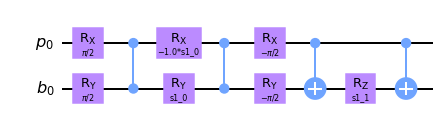

In [13]:

## qiskit-based circuit
## CREATE ISOMPS FROM PARAMETERIZED CIRCUIT ANSATZ ##
# initialize registers

preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
#creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Bond-state prep-circuit ##
bond_prep_params = [qk.circuit.Parameter('bp_'+str(j)) 
                    for j in range(n_bond_params)]
bond_prep_circ = qk.QuantumCircuit(breg)
if use_bond_prep:
    if nb==1: circuits.add_1q_circ(bond_prep_circ, breg[0], bond_prep_params) 
    elif nb==2: circuits.add_su4_circ(bond_prep_circ, breg[0],breg[1], bond_prep_params) 
else:
    bond_prep_circ.ry(0.234,breg)

# turn into custom parameterized circuit object
bond_prep_pcirc = QKParamCircuit(bond_prep_circ,bond_prep_params)


## Site Circuits ##
# create list of circuits, one for each site in the unit cell (uc)
site_circs = [qk.QuantumCircuit(preg,breg) for j in range(l_uc)]
# create a list of parameter-lists, (one list of parameters per site in uc)
site_circ_params = [[qk.circuit.Parameter('s'+str(j)+'_'+str(k))
                     for k in range(n_site_param)] 
                    for j in range(l_uc)]
site_pcircs=[] # list of QKParamCirc's for each site in uc
for j in range(l_uc):
    if j%2==0: site_circs[j].x(preg[0]) # alternating 10101010... for physical qubit
    
    # star circuit of xxz-type 2-qubit gates
    for k in range(nb): 
        circuits.add_xxz_circ(site_circs[j], 
                              preg[0], breg[k], 
                              site_circ_params[j][2*k:2*(k+1)])
    # combine into parameterized circuit
    site_pcircs += [QKParamCircuit(site_circs[j], site_circ_params[j])]

# create holopy isoMPS
psi = IsoMPS(preg,breg,site_pcircs,boundary_circuit=bond_prep_pcirc,L=L)

print('circuits for each site in uc:')
site_circs[1].draw('mpl')

# 3. Energy

In [5]:

# thermal-state-based Hamiltonian and boundary vects
Hamiltonian = model_mpo.xxz(J,Delta,hz,N)
chi_H = Hamiltonian[0,:,0,0].size # size of Hamiltonian bond leg dimension
H_bvecr = None
H_bvecl = np.zeros(chi_H)
H_bvecl[-1] = 1
bdry_vecs2 = [H_bvecl,H_bvecr]

In [6]:

# DMRG calculations

__all__ = ['XXZModel', 'XXChain']
class XXZModel(CouplingMPOModel):
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'parity')
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            if self.verbose >= 1.:
                print(self.name + ": set conserve to", conserve)
        site = SpinHalfSite(conserve=conserve)
        return site
    def init_terms(self, model_params):
        J = np.asarray(model_params.get('J', 1.))
        d = np.asarray(model_params.get('d', 1.))
        h = np.asarray(model_params.get('h', 1.))
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(h, u, 'Sigmaz')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(J, u1, 'Sigmax', u2, 'Sigmax', dx)
            self.add_coupling(J, u1, 'Sigmay', u2, 'Sigmay', dx)
            self.add_coupling(J*d, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        # done
        
class XXZChain(XXZModel, NearestNeighborModel):
    def __init__(self, model_params):
        model_params = asConfig(model_params, self.__class__.__name__)
        model_params.setdefault('lattice', "Chain")
        CouplingMPOModel.__init__(self, model_params)
        
        
def DMRG_xxz(J,Delta,hz,chi_max,bc,L,verbose=False):
    model_params = dict(L=L, J=J, d=Delta, h = hz, bc_MPS=bc, 
                        conserve=None, verbose=verbose)
    M = XXZChain(model_params)
    product_state = ["down"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-6
        },
        'max_E_err': 1.e-6,
        'verbose': verbose,
    }
    eng = tp.algorithms.dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    print("E_dmrg = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.mean(psi.expectation_value("Sigmax"))
    mag_z = np.mean(psi.expectation_value("Sigmaz"))
    print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
    print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
    #print("correlation length:", psi.correlation_length())
    if bc == 'infinite':
        E1 = E
    else:
        E1 = E/L
    return E1

In [7]:
E_infinite = DMRG_xxz(J,Delta,hz,chi_max = 2,bc='infinite',L=2,verbose=False)
E_finite = DMRG_xxz(J,Delta,hz,chi_max = 2,bc='finite',L=L,verbose=False)

E_dmrg = -1.8478874923720
final bond dimensions:  [2, 2]
<sigma_x> = 0.00000
<sigma_z> = 0.00000


/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


E_dmrg = -36.5280232247023
final bond dimensions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
<sigma_x> = -0.00000
<sigma_z> = 0.00000


/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/algorithms/dmrg.py:420: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


I) Free energy for classical circuit structure:

In [10]:

# testing for finite MPDO (for classical structure)
T = 0
def circuit_qubit_free_energy(x,*args):
    circuit = args[0]
    L = args[1]
    T = args[2]
    Hamiltonian = args[3]
    chi_H = args[4]
    bdry_vecs1 = args[5]
    bdry_vecs2 = args[6]
    l_uc = args[7]
    unitary_list = [circuit.get_tensor(x[l_uc:l_uc+6]),circuit.get_tensor(x[l_uc+6:])]
    F = thermal_state.free_energy(unitary_list,
                                  x,'density_matrix',
                                  L,Hamiltonian,
                                  T, chi_H,
                                  bdry_vecs1,bdry_vecs2,
                                  'method_I',None) 
    return F

bdry_vecs1 = [None,None]
#### bdry_vecs1 = TBD for MPDO, bdry_vecs1 = [None,None] and for iMPDO, bdry_vecs1 = None
Hamiltonian = model_mpo.xxz(J,Delta,hz,N)
args = (c,L,T,Hamiltonian,chi_H,bdry_vecs1,bdry_vecs2,l_uc)
rng = np.random.default_rng()
x0 = rng.uniform(high=2*np.pi,size = c.n_params*2 + l_uc)
result = minimize(circuit_qubit_free_energy,x0=x0,args=args,method = 'nelder-mead')
sweet_spot = result.x
free_energy = result.fun
print(f'Free energy = {free_energy}, T = {T}')
print(f'DMRG estimate (finite length): {E_finite}')
print(f'DMRG estimate (infinite length): {E_infinite}')

Free energy = -1.8388845019233833, T = 0
DMRG estimate (finite length): -1.8264011612351148
DMRG estimate (infinite length): -1.847887492372024


In [11]:
print(x0)
print(sweet_spot)

[1.63489407 2.08963227 3.5289182  0.39401093 3.84153053 5.21442816
 4.15250714 0.49224119 2.05186605 0.09067592 0.80545431 3.57805798
 3.04601923 6.13469376]
[-2.49045144e+00  7.98700195e+00  3.14205925e+00 -2.83605527e-03
  6.51816319e+00  5.34050834e+00  3.76030397e+00 -2.05098949e-02
  1.57210573e+00  4.35734723e-02  1.59251241e+00  2.20371698e+00
  2.51234859e+00  6.28742844e+00]


II) Free energy for qiskit-based circuit structure:

In [14]:

# finding the optimized params (for qiskit-based structure)

def energy_tp(param_vals,*args):
    """
    function to calculate energy using MPO/MPS contraction in tenpy
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
            args[2] should be N: number of sites
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi = args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    N = args[2]
    param_dict = dict(zip(psi.param_list,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    site = SpinHalfSite(conserve = None)
    state_list = psi.L*psi.tensors(param_dict)
    B_arrs = [np.swapaxes(tensor,1,2) for tensor in state_list]
    B_arrs[0] = B_arrs[0][:,0:1,:]
    B_arrs[-1] = B_arrs[-1][:,:,0:1]
    psi_tp = MPS.from_Bflat([site]*N,B_arrs,bc = 'finite',dtype=complex,form=None) 
    
    psi_tp.canonical_form()
    psi_tp.convert_form(psi_tp.form)
    # compute energy
    E = (H_mpo.expectation_value(psi_tp)).real
    return E

def tp_xxz_mpo(J, Delta, hz, N):
    """
    TenPy-based Heisenberg xxz chain MPO structure
    """
    site = SpinHalfSite(None)
    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
    Sx, Sy = (Sp + Sm), -1j*(Sp - Sm)
    H_bulk = [[Id, Sx, Sy, Sz, hz * Sz],
              [None, None, None, None, J * Sx],
              [None, None, None, None, J * Sy],
              [None, None, None, None, J * Delta * Sz],
              [None, None, None, None, Id]]
        
    H_first = [H_bulk[0]] # first row
    H_last = [[row[-1]] for row in H_bulk] # last column
    H_list = [H_first] + [H_bulk]*(N - 2) + [H_last]  
    H1 = thermal_state.network_from_cells(H_list,'MPO',N,None,None,None,'tenpy',None)      
    return H1

# starting point for parameters
x0 = np.pi*np.random.randn(psi.n_params) 
t0 = time.time()
args = (psi,tp_xxz_mpo(J,Delta,hz,N),N)
opt_result = minimize(energy_tp,x0,args=args,method='BFGS')
tf = time.time()

# set parameters to previously optimized values
opt_vals = opt_result.x
opt_params = dict(zip(psi.param_list,opt_vals))
E_gs_tp = opt_result.fun
print('Optimization done, elapsed time: {}'.format(tf-t0))
print('Optimized parameters')
print(opt_params)

Optimization done, elapsed time: 49.75008773803711
Optimized parameters
{Parameter(s0_0): 1.23744147998543, Parameter(s0_1): 3.141592475863576, Parameter(s1_0): -7.551458537789436, Parameter(s1_1): 3.141592294111724}


In [15]:

# testing for finite MPDO (for qiskit-based structure)
T = 0
def circuit_qubit_free_energy(params,*args):
    """
    Free energy (using density matrix)
    """
    psi = args[0]
    Hamiltonian = args[1]
    chi_H = args[2]
    T = args[3]
    prob_params = args[4]
    bdry_vecs1 = args[5]
    bdry_vecs2 = args[6] 
    L = args[7]
    params1 = dict(zip(psi.param_list,params))
    tensors = psi.as_mpo(params1).tensors
    params2 = np.concatenate((prob_params,list(params)))

    F = thermal_state.free_energy(tensors,params2,
                                  'density_matrix',L,
                                  Hamiltonian,T,
                                  chi_H,bdry_vecs1,
                                  bdry_vecs2,'method_I',
                                  None)   
    return F

#### bdry_vecs1 = TBD for MPDO, bdry_vecs1 = [None,None] and for iMPDO, bdry_vecs1 = None
bdry_vecs1 = [None,None]
rng = np.random.default_rng() 
probs_params = rng.uniform(high=2*np.pi,size =4)
args = (psi,Hamiltonian,chi_H,T,probs_params,bdry_vecs1,bdry_vecs2,L)
new_params = np.concatenate((probs_params,list(opt_vals)))
result = minimize(circuit_qubit_free_energy,x0=new_params,args=args,method='nelder-mead')
sweet_spot = result.x
free_energy = result.fun

print(f'Free energy = {free_energy}, T = {T}')
print(f'TenPy estimate = {E_gs_tp/N}')
print(f'DMRG estimate (finite length): {E_finite}')
print(f'DMRG estimate (infinite length): {E_infinite}')

Free energy = -1.8461247950778346, T = 0
TenPy estimate = -1.8428114453377742
DMRG estimate (finite length): -1.8264011612351148
DMRG estimate (infinite length): -1.847887492372024
